In [1]:
from game2048.game import Game
from game2048.displays import Display, IPythonDisplay
from game2048.agents import Agent, RandomAgent, ExpectiMaxAgent
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization
import numpy as np
import random
from collections import deque
from keras.optimizers import RMSprop, Adam
import time
import os
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
display1 = Display()
display2 = IPythonDisplay()

In [ ]:
game = Game(4, random=False)
display1.display(game)
display2.display(game)
agent = RandomAgent(game, display=display1)
agent.play(verbose=True)

In [ ]:
game = Game(4, random=False)
agent = Agent(game, display=display2)
agent.play(verbose=True)

In [ ]:
%%time
game = Game(4, score_to_win=2048, random=False)
display2.display(game)
agent = ExpectiMaxAgent(game, display=display2)
agent.play(verbose=True)

In [ ]:
%%time
# a random start
game = Game(4, score_to_win=2048, random=True)
display2.display(game)
agent = ExpectiMaxAgent(game, display=display2)
agent.play(verbose=True)

In [ ]:
for _ in range(10):
    print("The ExpectiMax agent always search a fixed solution given certain board:",
          agent.step())

In [ ]:
print("Running the loop manually...")

game = Game(4, random=False, enable_rewrite_board=False)
agent = RandomAgent(game)

for _ in range(10):
    direction = agent.step()
    print("Moving to direction `%s`..."%direction)
    game.move(direction)
    display1.display(game)
    display2.display(game)

In [10]:
game.board = game.board

Disable to rewrite `board` manually.


In [11]:
game.enable_rewrite_board = True

In [12]:
game.board = game.board

### Deep Q-learning

In [10]:
game = Game(4, random=True, score_to_win=2048)
randomAgent = RandomAgent(game, display = display1)
display1.display(game)
randomAgent.step()
display1.display(game)
expectimax = ExpectiMaxAgent(game)
expectimax.step()

State:	       4      32      64     512
	       2     512       2       4
	       8      64      64     256
	      32     256     256      32
Score: 512
State:	       4      32      64     512
	       2     512       2       4
	       8      64      64     256
	      32     256     256      32
Score: 512
Loaded expectmax lib for 2048: /home/myx/learning_affairs/EE228/project/2048-api/game2048/expectimax/bin/2048.so


2

In [10]:
class DQNAgent(Agent):

    def __init__(self, game, display=None):
        self.game = game
        self.memory = deque(maxlen=500000)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.005
        self.epsilon_decay = (self.epsilon - self.epsilon_min) / 1000000

        self.batch_size = 32
        self.train_start = 20000
        self.state_size = 16
        self.action_size = 4
        self.learning_rate = 0.00025

        self.evaluation_model = self.create_model()
        self.target_model = self.create_model()

    def create_model(self):
        """
        creates evaluation and train model
        """
        model = Sequential()
        model.add(Dense(128, input_shape=(16,),  activation='relu', kernel_initializer="he_uniform"))
        model.add(Dense(128, activation='relu', kernel_initializer="he_uniform"))
        model.add(Dense(128, activation='relu', kernel_initializer="he_uniform"))
        model.add(Dense(128, activation='relu', kernel_initializer="he_uniform"))
        model.add(Dense(128, activation='relu', kernel_initializer="he_uniform"))
        model.add(Dense(4, activation='softmax', kernel_initializer="he_uniform"))
        optimizer = Adam(lr=self.learning_rate)
        model.compile(loss="mean_squared_error", optimizer=optimizer)
        return model

    def step(self, count):
        """
        returns the action chosen by this agent based on how many count of steps it has gone
        """
        if count > 10:
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decay
        if np.random.random() < self.epsilon:
            return np.random.randint(0, 4)
        return np.argmax(self.evaluation_model.predict(self.game.board.reshape(1,16))[0])

    def remember(self, observation, action, reward, observation_, done, teacher_action):
        """
        stores the transition in memory
        """
        self.memory.append((observation, action, reward, observation_, done, teacher_action))
        return

    def replay(self):
        """
        replays memory to learn
        """
        if len(self.memory) < self.train_start:
            return

        max_batch = random.sample(self.memory, self.batch_size * 10)
        half_batch = sorted(max_batch, key=lambda i: i[2], reverse=True)[:self.batch_size // 2 + 1]
        random_batch = random.sample(self.memory, self.batch_size // 2 + 1)
        mini_batch = half_batch + random_batch

        update_input = np.zeros((self.batch_size, self.state_size))
        update_target = np.zeros((self.batch_size, self.action_size))

        for i in range(self.batch_size):
            state, action, reward, new_state, done, teacher_action = mini_batch[i]
            target = self.evaluation_model.predict(state)[0]

            if done:
                target[action] = reward
            else:
                target[action] = reward + self.gamma * np.amax(self.target_model.predict(new_state)[0])

            update_input[i] = state
            update_target[i] = target

        self.evaluation_model.fit(update_input, update_target, batch_size=self.batch_size, epochs=1, verbose=0)
        return

    def target_train(self):
        """
        give the target network the weight of the network evaluation
        """
        self.target_model.set_weights(self.evaluation_model.get_weights())
        return

In [13]:
episodes = 1001
trial_len = 1000
tmp_reward = 0
sum_rewards = 0
graph_reward = []
graph_episodes = []

In [16]:
game = Game(4, random=False, score_to_win=2048)
dqn_agent = DQNAgent(game)
count = 0

for episode in range(episodes):
    game = Game(4, random=False, score_to_win=2048)
    dqn_agent.game = game
    observation = dqn_agent.game.board.reshape(1,16)
    tmp_reward = 0
    reward = 0
    while True:
        count += 1
        action = dqn_agent.step(count)
        expectimax = ExpectiMaxAgent(game)
        teacher_action = expectimax.step()
        reward, done = dqn_agent.game.move(action)
        observation_ = dqn_agent.game.board.reshape(1,16)
        reward = int(teacher_action==action)
        tmp_reward += reward
        dqn_agent.remember(observation, action, reward, observation_, done, teacher_action)
        if count%4 == 0:
            dqn_agent.replay()
        observation = observation_
        if done:
            if count >= 2500 and count%2500 == 0:
                dqn_agent.target_train()
            break
    sum_rewards += tmp_reward
    if episode % 100 == 0:
        print(episode)
        print(sum_rewards/100)
        sum_rewards = 0

0
48.54
100
14.68
200
14.5
300
14.87
400
14.48
500
14.43
600
15.5
700
14.8
800
14.6
900
14.89
1000
15.4


### rl-2048

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.optimizers import Adam
from keras import layers
from collections import deque
import numpy as np
import random

Using TensorFlow backend.


In [13]:
from game2048.game import Game
from game2048.displays import Display, IPythonDisplay
from game2048.agents import Agent, RandomAgent, ExpectiMaxAgent

max_tile = []

In [14]:
#Converting observations in range (0,1) using log(n)/log(max) so that gradients don't vanish
def process_log(observation):
        observation_temp = np.where(observation <= 0, 1, observation) 
        processed_observation = np.log2(observation_temp)/np.log2(65536)
        return processed_observation.reshape(1,4,4)

In [15]:
def get_grids_next_step(grid):
        #Returns the next 4 states s' from the current state s
        
        grids_list = []
        
        for movement in range(4):
            grid_before = grid.copy()
            env1 = Game(4, random=False, enable_rewrite_board=True)
            env1.board = grid_before
            try:
                _ = env1.move(movement) 
            except:
                pass
            grid_after = env1.board
            grids_list.append(grid_after)
            
        return grids_list

In [16]:
class DQN:
    def __init__(self,env):
        #Defining the hyperparameters for the model
        self.env=env.board
        #The replay memory will be stored in a Deque
        self.memory=deque(maxlen=2000)
        self.gamma=0.90
        #self.epsilon=1.0
        self.epsilon_min=0.01
        self.epsilon_decay=0.995
        self.learning_rate=0.005
        self.epsilon=pow(self.epsilon_decay, 1000)
        self.tau=0.125
        #We use 2 models to prevent Bootstrapping
        #self.model=self.create_model()
        #self.target_model=self.create_model()
        self.model = keras.models.load_model('result1/trial num-4767.h5f')
        self.target_model = keras.models.load_model('result1/trial num-4767.h5f')
        
        
    def create_model(self):
        model=Sequential()
        state_shape=4
                
        model.add(Flatten(input_shape=(4,4)))
        model.add(Dense(units=1024,activation="relu"))
        model.add(Dense(units=512,activation="relu"))
        model.add(Dense(units=256,activation="relu"))
        model.add(Dense(units=4))
        model.compile(loss="mean_squared_error",optimizer=Adam(lr=self.learning_rate))
        print(model.summary())
        return model
                  
    def act(self,state):
        #Epsilon value decays as model gains experience
        self.epsilon*=self.epsilon_decay
        self.epsilon=max(self.epsilon_min,self.epsilon)
        if np.random.random()<self.epsilon:
                  return np.random.randint(0,4)
        else:
            #Getting the 4 future states
            allstates=get_grids_next_step(state)
            
            res=[]
            for i in range(len(allstates)):
                if (allstates[i]==state).all():
                    res.append(0)
                else:
                    processed_state=process_log(allstates[i])
                    #max from the 4 future Q_Values is appended in res
                    res.append(np.max(self.model.predict(processed_state)))
            
            a=self.model.predict(process_log(state))
            #Final Q_Values are the sum of Q_Values of current state andfuture states
            final=np.add(a,res)
            
            return np.argmax(final)
    
    def remember(self, state, action, reward, new_state, done):
        #Replay Memory stores tuple(S, A, R, S')
        self.memory.append([state, action, reward, new_state, done])

    def replay(self):
        batch_size=32
        if len(self.memory)<batch_size:
            return
        samples=random.sample(self.memory,batch_size)
        for sample in samples:
            
            state,action,reward,new_state,done=sample
            
            target=self.target_model.predict(process_log(state))
            
            
            if done:
                target[0][action]=reward
            else:
                #Bellman Equation for update
                Q_future=max(self.target_model.predict(process_log(new_state))[0])
                
                #The move which was selected, its Q_Value gets updated
                target[0][action]=reward+Q_future*self.gamma
            self.model.fit((process_log(state)),target,epochs=1,verbose=0)
                  
                  
    def target_train(self):
        weights=self.model.get_weights()
        target_weights=self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i]=weights[i]*self.tau+target_weights[i]*(1-self.tau)
        self.target_model.set_weights(target_weights)
                  
                  
    def save_model(self,fn):
        self.model.save(fn)

In [17]:
def main():
    env = Game(4, random=False)
    gamma = 0.9
    epsilon = 0.95
    
    trials = 100
    trial_len = 5000
    dqn_agent = DQN(env=env)
    steps = []
    
    
    
    for trial in range(trials):
        env = Game(4, random=False)
        cur_state=env.board
        stepno=0
        
        for step in range(trial_len):
            stepno+=1
            
            action=dqn_agent.act(cur_state)
            
            reward,done = env.move(action)
            new_state=env.board
            
            dqn_agent.remember(cur_state,action,reward,new_state,done)
            if step%10==0:
                dqn_agent.replay()
                dqn_agent.target_train()
            
            cur_state=new_state
            
            if done:
                
                break
        
        if stepno<500:
            
            if int(env.board.max())==2048:
                print("Completed in --",trial)
                # print(env.get_board())
                max_tile.append(int(env.board.max()))

                dqn_agent.save_model("success.h5f")

            
            else:
                # print(f"Trial number {trial} Failed to complete in 500 steps")
                # print(env.get_board())
                print(int(env.board.max()))
                max_tile.append(int(env.board.max()))
                if int(env.board.max())>=512:
                    dqn_agent.save_model("trial num-{}.h5f".format(trial))
                    
        else:
            print(f"Failed to complete in 500 steps")
            # print(env.get_board())
            print(int(env.board.max()))
            max_tile.append(int(env.board.max()))
            
    dqn_agent.save_model("final.h5f")

            
if __name__ == "__main__":
    main()  

64
128
256
128
64
128
32
128
64
128
128
256
128
64
128
256
128
128
64
64
128
128
64
128
128
128
64
64
64
128
128
64
64
64
64
64
256
256
64
64
64
64
128
64
64
256
128
64
128
128
128
64
64
64
128
128
64
128
128
128
256
64
64
64
128
128
128
128
64
64
256
32
256
128
64
256
128
128
128
256
128
64
128
64
64
256
128
64
128
128
128
128
32
128
128
128
256
64
32
64


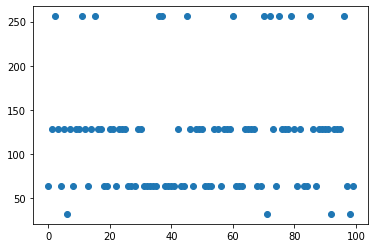

In [18]:
import matplotlib.pyplot as plt

trialnum=np.arange(100)
plt.scatter(trialnum,max_tile)

### supervised learning

In [4]:
from keras.models import Sequential,Model
from keras import layers
from keras import Input
from game2048.game import Game
from game2048.displays import Display, IPythonDisplay
from game2048.agents import Agent, RandomAgent, ExpectiMaxAgent
import numpy as np
import math

In [7]:
def change_values(X):
    power_mat = np.zeros(shape=(4,4,16),dtype=np.float32)
    for i in range(4):
        for j in range(4):
            if(X[i][j]==0):
                power_mat[i][j][0] = 1.0
            else:
                power = int(math.log(X[i][j],2))
                power_mat[i][j][power] = 1.0
    return power_mat

In [6]:
input_layer = Input(shape=(4,4,16),name='boards')
conv1 = layers.Conv2D(filters=128, kernel_size=(1,2),activation='relu')(input_layer)
conv2 = layers.Conv2D(filters=128, kernel_size=(2,1),activation='relu')(input_layer)
conv3 = layers.Conv2D(filters=128, kernel_size=(1,2),activation='relu')(conv1)
conv4 = layers.Conv2D(filters=128, kernel_size=(2,1),activation='relu')(conv1)
conv5 = layers.Conv2D(filters=128, kernel_size=(1,2),activation='relu')(conv2)
conv6 = layers.Conv2D(filters=128, kernel_size=(2,1),activation='relu')(conv2)
conv1 = layers.Flatten()(conv1)
conv2 = layers.Flatten()(conv2)
conv3 = layers.Flatten()(conv3)
conv4 = layers.Flatten()(conv4)
conv5 = layers.Flatten()(conv5)
conv6 = layers.Flatten()(conv6)
concat = layers.concatenate([conv1, conv2, conv3, conv4, conv5, conv6], axis = -1)
fullcon = layers.Dense(256)(concat)
output = layers.Dense(4, activation='softmax')(fullcon)
model = Model(input_layer, output)
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
boards (InputLayer)             (None, 4, 4, 16)     0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 4, 3, 128)    4224        boards[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 3, 4, 128)    4224        boards[0][0]                     
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 4, 2, 128)    32896       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [7]:
def generate_boards_actions(BS):
    game = Game(4)
    agent = ExpectiMaxAgent(game=game)
    actions = []
    boards = []
    while True:
        action = agent.step()
        board = change_values(game.board)
        game.move(action)
        action_mat = np.zeros(shape=(4),dtype=np.float32)
        action_mat[action] = 1
        actions.append(action_mat)
        boards.append(board)
        if game.end:
            game = Game(4)
            agent.game = game
        if len(actions)==BS:
            yield (np.array(boards), np.array(actions))
            actions = []
            boards = []

In [8]:
NUM_TRAIN = 500000
NUM_TEST = 300
BS = 100
NUM_EPOCHS = 2

H = model.fit_generator(
	generate_boards_actions(BS),
	steps_per_epoch=NUM_TRAIN // BS,
	validation_data=generate_boards_actions(BS),
	validation_steps=NUM_TEST // BS,
	epochs=10)

Epoch 1/10
Loaded expectmax lib for 2048: /home/myx/learning_affairs/EE228/project/2048-api/game2048/expectimax/bin/2048.so
5000/5000 [==============================] - 30737s 6s/step - loss: 1.1768 - accuracy: 0.4279 - val_loss: 1.1603 - val_accuracy: 0.4533
Epoch 2/10
 842/5000 [====>.........................] - ETA: 6:43:33 - loss: 1.1435 - accuracy: 0.4493

KeyboardInterrupt: 

In [10]:
model.save('CNN.h5')

In [20]:
from keras.models import load_model
model = load_model('CNN.h5')
game = Game(4, random=True)
model.predict(change_values(game.board).reshape(1,4,4,16))

array([[0.46737993, 0.21000558, 0.19786009, 0.12475433]], dtype=float32)

In [21]:
agent = ExpectiMaxAgent(game=game)
print(agent.step())

1


### DCNN

In [7]:
# -*- coding: utf-8 -*-
from numpy.random import *
import tensorflow as tf
import numpy as np
import math
import random
import os
from game2048.game import Game
from game2048.displays import Display, IPythonDisplay
from game2048.agents import Agent, RandomAgent, ExpectiMaxAgent, DCNNAgent
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [2]:
#フィルタ
w_1 = 222
w_2 = 222
w_3 = 222
w_4 = 222
w_5 = 222

#入力をチャネルごとに分解 (入力 深さ 縦 横 ch)
x_image = tf.placeholder(tf.float32, [None, 4, 4, 16])

#1層目のチャネルごとの畳み込みフィルタ初期化
W_conv1 = tf.Variable(tf.truncated_normal([2,2,16,w_1], stddev=0.1))

#1層目の畳み込み処理
h_conv1 = tf.nn.conv2d(x_image, W_conv1, strides=[1,1,1,1], padding='SAME')

#bias
b_conv1 = tf.Variable(tf.constant(0.1, shape=[w_1]))

#1層目のReLU処理
relu1 = tf.nn.relu(h_conv1 + b_conv1)

#2層目
W_conv2 = tf.Variable(tf.truncated_normal([2,2,w_1,w_2], stddev=0.1))
h_conv2 = tf.nn.conv2d(relu1, W_conv2, strides=[1,1,1,1], padding='SAME')
b_conv2 = tf.Variable(tf.constant(0.1, shape=[w_2]))
relu2 = tf.nn.relu(h_conv2 + b_conv2)

#3層目
W_conv3 = tf.Variable(tf.truncated_normal([2,2,w_2,w_3], stddev=0.1))
h_conv3 = tf.nn.conv2d(relu2, W_conv3, strides=[1,1,1,1], padding='SAME')
b_conv3 = tf.Variable(tf.constant(0.1, shape=[w_3]))
relu3 = tf.nn.relu(h_conv3 + b_conv3)

#4層目
W_conv4 = tf.Variable(tf.truncated_normal([2,2,w_3,w_4], stddev=0.1))
h_conv4 = tf.nn.conv2d(relu3, W_conv4, strides=[1,1,1,1], padding='SAME')
b_conv4 = tf.Variable(tf.constant(0.1, shape=[w_4]))
relu4 = tf.nn.relu(h_conv4 + b_conv4)

#5層目
W_conv5 = tf.Variable(tf.truncated_normal([2,2,w_4,w_5], stddev=0.1))
h_conv5 = tf.nn.conv2d(relu4, W_conv5, strides=[1,1,1,1], padding='SAME')
b_conv5 = tf.Variable(tf.constant(0.1, shape=[w_5]))
relu5 = tf.nn.relu(h_conv5 + b_conv5)

#線形にする
relu5_flat = tf.reshape(relu5, [-1, 4*4*w_5])

#全結合層/ソフトマックス
w0 = tf.Variable(tf.zeros([4*4*w_5, 4]))
b0 = tf.Variable(tf.zeros([4]))
p = tf.nn.softmax(tf.matmul(relu5_flat, w0) + b0)

#学習箇所
t = tf.placeholder(tf.float32, [None, 4])
loss = -tf.reduce_sum(t * tf.log(tf.clip_by_value(p,1e-10,1.0)))
train_step = tf.train.AdamOptimizer().minimize(loss)

#正答率
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#セッション用意
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(max_to_keep=None)

In [3]:
files = '/home/myx/learning_affairs/EE228/project/2048-DCNN/c5_pdata/c5-' + str(600000000)
saver.restore(sess, files)

INFO:tensorflow:Restoring parameters from /home/myx/learning_affairs/EE228/project/2048-DCNN/c5_pdata/c5-600000000


In [4]:
def change_values(X):
    power_mat = np.zeros(shape=(4,4,16),dtype=np.float32)
    for i in range(4):
        for j in range(4):
            if(X[i][j]==0):
                power_mat[i][j][0] = 1.0
            else:
                power = int(math.log(X[i][j],2))
                power_mat[i][j][power] = 1.0
    return power_mat

In [8]:
game = Game(4, random=False)
agent = DCNNAgent(game=game)

INFO:tensorflow:Restoring parameters from /home/myx/learning_affairs/EE228/project/2048-DCNN/c5_pdata/c5-600000000


NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key Variable_12 not found in checkpoint
	 [[Node: save_2/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_2/Const_0_0, save_2/RestoreV2/tensor_names, save_2/RestoreV2/shape_and_slices)]]

Caused by op 'save_2/RestoreV2', defined at:
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 597, in start
    self.io_loop.start()
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/asyncio/base_events.py", line 442, in run_forever
    self._run_once()
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/asyncio/base_events.py", line 1462, in _run_once
    handle._run()
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 545, in execute_request
    user_expressions, allow_stdin,
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-9faedf753583>", line 2, in <module>
    agent = DCNNAgent(game=game)
  File "/home/myx/learning_affairs/EE228/project/2048-api/game2048/agents.py", line 282, in __init__
    self.saver = tf.train.Saver(max_to_keep=None)
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1281, in __init__
    self.build()
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1293, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1330, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 778, in _build_internal
    restore_sequentially, reshape)
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 397, in _AddRestoreOps
    restore_sequentially)
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 829, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1463, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/home/myx/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

NotFoundError (see above for traceback): Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key Variable_12 not found in checkpoint
	 [[Node: save_2/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_2/Const_0_0, save_2/RestoreV2/tensor_names, save_2/RestoreV2/shape_and_slices)]]


In [4]:
agent.play(verbose=True)

In [5]:
print(game.score)

64
